week 5 미션 제출
=============

#### Imports

In [10]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm.notebook import tnrange

#### Q1. 가장 먼저 학습 데이터를 준비해보도록 하겠습니다. MNIST 데이터셋을 직접 Load해 봅시다. 데이터셋을 로드하고 DataLoader를 구현해보세요.

- DataLoader를 이용해 MNIST 데이터셋을 로드해봅시다.

#### Hyperparameters
- 하이퍼 파라미터 변수를 미리 모두 지정하였습니다.

In [11]:
# Hyperparameter
H, W = 28, 28
channel = 3
input_size = H * W
num_classes = 10
learning_rate = 0.01
training_epochs = 15
batch_size = 100

root = '../data'

#### Load Data
- 오류를 막기 위해 transform을 transforms.ToTensor()로 합니다. (transforms.ToTensor(): Convert a PIL(파이썬 이미지 분석 라이브러리) Image or numpy.ndarray to tensor)

In [12]:
# load data
mnist_train = dset.MNIST(root=root, train=True, transform=transforms.ToTensor(), download=True)
mnist_test = dset.MNIST(root=root, train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)

#### Q2.데이터가 준비가 되었다면, 이제 그 데이터를 학습할 모델을 구현할 차례입니다. 그 후 모델 안의 가중치를 초기화시켜보세요. 입력 데이터 형태에 맞도록 linear한 모델을 구성해보세요.

- MNIST 입력의 크기는 28x28입니다.

- 여기서 구현하는 linear 모델은 입력이 1차원이기 때문에 입력 차원을 맞춰보세요.

#### Check Hardware

In [13]:
# check cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Build and Initialize Model
- 위에서 정의한 하이퍼 파라미터를 사용해 모델을 정의합니다.

In [14]:
# build linear model
linear = nn.Linear(in_features=input_size, out_features=num_classes, bias=True).to(device)

# weight init
torch.nn.init.normal_(linear.weight)

Parameter containing:
tensor([[ 1.1093, -0.4664,  0.1216,  ...,  0.6209,  0.6965,  0.2796],
        [-0.5280,  0.0859,  0.7089,  ...,  0.4711,  0.4729,  0.4679],
        [-0.5498,  0.3682,  0.7501,  ..., -0.1296, -0.2005, -0.7669],
        ...,
        [-0.8352,  0.6720,  0.1290,  ...,  1.8986,  0.0663, -1.1350],
        [-0.3848,  0.1273, -2.8399,  ..., -0.0984,  0.1453,  0.2929],
        [-1.2537,  0.7865, -2.8980,  ..., -0.8135,  1.6669, -0.1770]],
       device='cuda:0', requires_grad=True)

#### Q3. 위에서 구현한 모델을 학습시키기 위해서는 loss 함수와 opitmizer가 필요합니다. 아래 제시된 loss 함수와 optimizer를 구현해보세요. Loss 함수와 optimizer는 모델 안의 가중치를 업데이트 할 때 사용됩니다.

- 옵티마이저는 SGD, Loss는 Cross Entropy Loss를 사용합니다.

#### Loss and optimizer

In [15]:
# Loss fn - Cross Entropy Loss
criterion = torch.nn.CrossEntropyLoss().to(device)

# optimizer - SGD
optimizer = torch.optim.SGD(linear.parameters(), lr = learning_rate)

#### Q4. 3번 문제까지 해결하셨다면, 이제 학습을 위한 준비는 거의 끝났다고 볼 수 있습니다. 위 구현 함수들을 이용해 학습 Loop를 구현해보세요.

- 위에서 구현한 모델, optimzer, loss fn 등을 이용해 학습을 구현해주세요.

#### Train
- 학습 loop 코드입니다.
- print문 대신 tqdm을 사용하여 움직이는 출력으로 변경하였습니다. 출력의 길이를 감소하고, 가독성을 높였습니다.

In [19]:
loss_list = [] # 학습되는 동안 loss의 변화를 기록할 리스트
accuracy_list = [] # 학습되는 동안 accuracy의 변화를 기록할 리스트

t = tnrange(training_epochs, leave=True) # tqdm 객체 생성

for epoch in t:
    t.set_description("Epoch [{}/{}]".format(epoch+1, training_epochs), refresh=True) # tqdm의 description 수정

    temp_loss_list = [] # 배치별로 계산된 loss를 저장할 임시 리스트
    temp_accuracy_list = [] # 배치별로 계산된 accuracy를 저장할 임시 리스트

    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        imgs = imgs.view(-1, 28 * 28)

        outputs = linear(imgs) # imgs를 linear layer의 입력으로 넣어 classifier가 분류한 결과를 얻는다.
        loss = criterion(outputs, labels) # classifier가 분류한 결과와 실제 label로 cross_entropy를 진행한다.

        optimizer.zero_grad() # optimizer zero grad / gradient 초기화
        loss.backward() # loss backward / gradient를 계산해서 업데이트
        optimizer.step() # optimizer step / 개선

        _, argmax = torch.max(outputs, 1) # max()를 이용해 최종 출력이 가장 높은 class 선택
        accuracy = (labels == argmax).float().mean()
        
        temp_loss_list.append(loss.item()) # 배치별로 계산된 loss를 임시 리스트에 저장
        temp_accuracy_list.append(accuracy.item()) # 배치별로 계산된 accuracy를 임시 리스트에 저장

        if (i+1) % 50 == 0:
            t.set_postfix_str('Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(i+1, len(train_loader), loss.item(), accuracy.item() * 100)) # tqdm 객체의 postfix 수정

    loss_list.append(sum(temp_loss_list)/len(temp_loss_list)) # 한 epoch 동안 loss를 기록
    accuracy_list.append(sum(temp_accuracy_list)/len(temp_accuracy_list)) # 한 epoch 동안 accuracy를 기록

  0%|          | 0/15 [00:00<?, ?it/s]

#### Train Visualize
- 학습되는 동안 기록된 Loss와 Accuracy를 출력합니다.

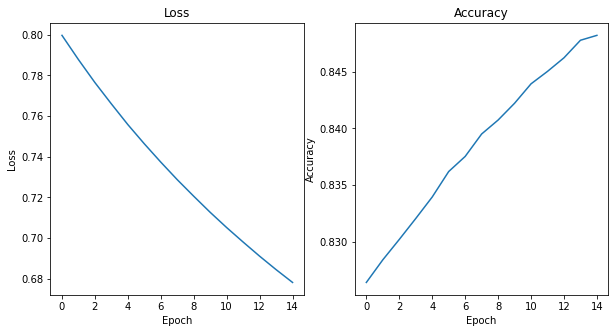

In [20]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss_list)

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy_list)

plt.show()

#### Q5. 학습이 완료되면, 모델이 잘 동작하는지 테스트가 필요합니다. 데이터로드 파트에서 준비했던 테스트 데이터를 이용해 테스트를 진행해봅시다. 아래 테스트 코드를 완성해보세요.

#### Test
- 테스트 코드입니다.

In [21]:
linear.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        imgs = imgs.view(-1, 28 * 28)

        outputs = linear(imgs)
        _, argmax = torch.max(outputs, 1) # max()를 통해 최종 출력이 가장 높은 class 선택
        total += imgs.size(0) # 모든 이미지의 수
        correct += (labels == argmax).sum().item() # label이 argmax와 일치하는 수 만큼 더하기

    print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))

Test accuracy for 10000 images: 85.94%
